# In-depth analysis Part 2

# Consumer Segmentation Miami

In this section we focus on the data from the Household Pulse Survey to find relationships between shopping variables and demographics, as well as applying Machine Learning techniques to generate customer segmentations.

In [1]:
import pandas as pd
import numpy as np
import indepth_functions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import prince
#!{sys.executable} -m pip install kmodes
from kmodes.kmodes import KModes
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('../data/interim/census/household_shopping_concat.csv')

In [3]:
df['GENERATION'] = df.TBIRTH_YEAR.apply(indepth_functions.generation_)

## Miami

In [4]:
#metro-area code
EST_MSA = 33100
name_location = 'Miami-Fort Lauderdale-Pompano Beach'

In [5]:
df_miami = df[df.EST_MSA == EST_MSA]

In [6]:
demographics = ['EGENDER', 'RHISPANIC', 
                    'RRACE',
                    'EEDUC', 'MS', 
                    'THHLD_NUMKID', 'THHLD_NUMADLT', 'INCOME', 'EXPNS_DIF'] 

We ignore the variable `THHLD_NUM` because it's the sum of adults and kids in the household.

In [7]:
shopping_vars = ['ONLINE','PICK-UP','IN-STORE','RFID-NFC', 'CASH', 'AVOID RESTR','RESUME RESTR']

In [8]:
df_miami.rename({'CHNGHOW1': 'ONLINE',
           'CHNGHOW2': 'PICK-UP',
           'CHNGHOW3': 'IN-STORE',
           'CHNGHOW4': 'RFID-NFC', 
           'CHNGHOW5': 'CASH', 
           'CHNGHOW6': 'AVOID RESTR',
           'CHNGHOW7': 'RESUME RESTR'}, axis=1, inplace=True)

In [9]:
df_miami.dropna(subset=demographics, inplace=True)

In [10]:
df_miami = df_miami.replace({np.nan: 0})

In [11]:
df_miami = df_miami.loc[:, demographics+shopping_vars]

In [12]:
df_miami.head()

,EGENDER,RHISPANIC,RRACE,EEDUC,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,EXPNS_DIF,ONLINE,PICK-UP,IN-STORE,RFID-NFC,CASH,AVOID RESTR,RESUME RESTR
136,1.0,1.0,1.0,7.0,5.0,0.0,2.0,7.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
647,2.0,1.0,2.0,6.0,1.0,0.0,5.0,1.0,4.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
648,1.0,2.0,1.0,7.0,1.0,2.0,6.0,8.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
653,2.0,1.0,1.0,6.0,3.0,1.0,3.0,8.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
654,2.0,2.0,1.0,3.0,5.0,1.0,2.0,2.0,4.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [13]:
df_miami.value_counts('EEDUC')

EEDUC
6.0    2111
7.0    1866
4.0    1305
5.0     814
3.0     621
2.0     109
1.0      26
dtype: int64

In [14]:
def income_bins(income):
    if income <=3:
        return 1
    elif income >3 and income <=4:
        return 2
    elif income >4 and income <=5:
        return 3
    elif income >5 and income <=6:
        return 4
    else:
        return 5

In [15]:
def educ_bins(educ):
    if educ <=3:
        return 1
    else:
        return educ-2

In [16]:
def kid_bins(kids):
    if kids >=3:
        return 3  
    return kids

In [17]:
def kid_adulsts(adults):
    if adults >=5:
        return 5 
    return adults

In [18]:
def zero_base(value):
    return value-1

In [19]:
df_miami['INCOME'] = df_miami['INCOME'].apply(income_bins)

In [20]:
df_miami['THHLD_NUMKID'] = df_miami['THHLD_NUMKID'].apply(kid_bins)

In [21]:
df_miami['THHLD_NUMADLT'] = df_miami['THHLD_NUMADLT'].apply(kid_adulsts)

In [22]:
df_miami['EEDUC'] = df_miami['EEDUC'].apply(educ_bins)

In [23]:
for col in ['EGENDER', 'RHISPANIC', 'RRACE','EEDUC', 'MS', 'INCOME', 'EXPNS_DIF']:
    df_miami[col] = df_miami[col].apply(zero_base)

In [24]:
df_miami.head()

,EGENDER,RHISPANIC,RRACE,EEDUC,MS,THHLD_NUMKID,THHLD_NUMADLT,INCOME,EXPNS_DIF,ONLINE,PICK-UP,IN-STORE,RFID-NFC,CASH,AVOID RESTR,RESUME RESTR
136,0.0,0.0,0.0,4.0,4.0,0.0,2.0,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
647,1.0,0.0,1.0,3.0,0.0,0.0,5.0,0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
648,0.0,1.0,0.0,4.0,0.0,2.0,5.0,4,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0
653,1.0,0.0,0.0,3.0,2.0,1.0,3.0,4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
654,1.0,1.0,0.0,0.0,4.0,1.0,2.0,0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [25]:
df_miami1 = df_miami.copy()

In [26]:
# x_cols = df_sf1
# K = np.arange(2, 12, 1)
# inertias = []

# for k in K:
#     model = KMeans(n_clusters=k)
#     model.fit(x_cols)
#     inertias.append(model.inertia_)
    
# f, ax = plt.subplots(figsize=(6.5, 6.5))  
# _ = plt.plot(inertias, linewidth=1, markersize=5, marker='o', linestyle='dashed', color='royalblue') 
# _ = plt.xlabel('clusters')
# _ = plt.ylabel('Sum of Squares')
# _ = plt.title('The Elbow Sum of Squares Method')
# plt.show()

For n_clusters = 2 The average silhouette_score is : 0.03984693012836303
For n_clusters = 3 The average silhouette_score is : 0.024604355394253385
For n_clusters = 4 The average silhouette_score is : 0.001663944371541757
For n_clusters = 5 The average silhouette_score is : -0.011527154481016494


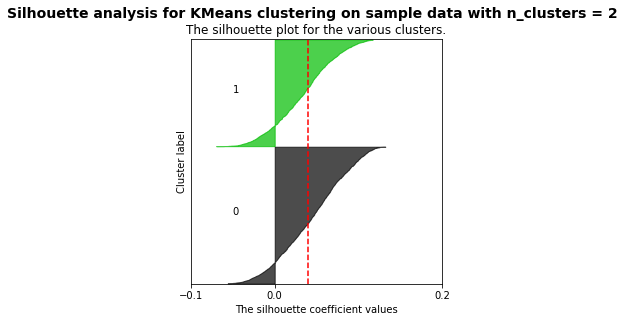

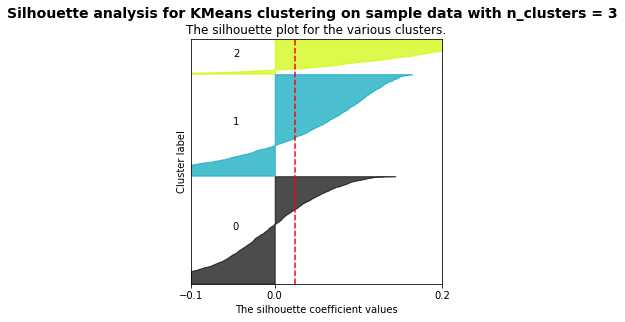

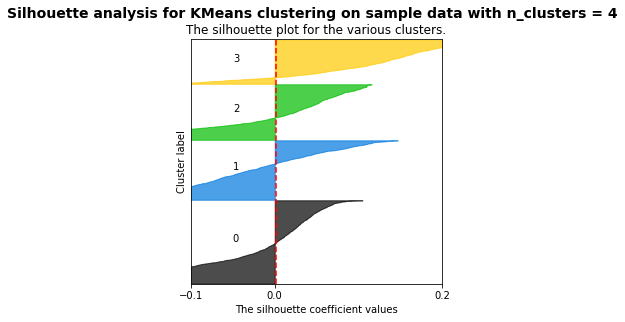

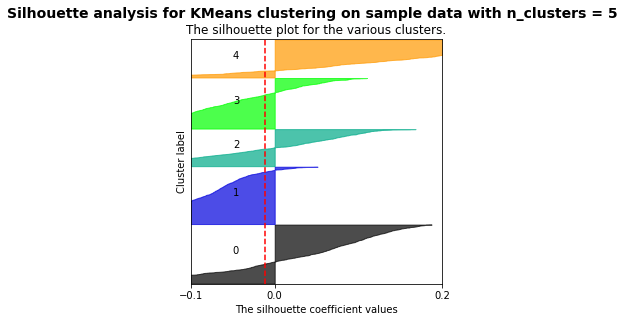

In [27]:
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# This particular setting has one distinct cluster and 3 clusters placed close
# together.
X = df_miami1.sample(5000, random_state=1)

range_n_clusters = [2, 3, 4, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots()
    fig.set_size_inches(4.5, 4.5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 0.2])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = km = KModes(n_clusters=n_clusters, init='Huang', n_init=5, verbose=0)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2])

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [49]:
km = KModes(n_clusters=3, init='Huang', n_init=5, verbose=0)
x_cols = df_miami.copy()
clusters = km.fit_predict(x_cols)

# Print the cluster centroids
print(km.cluster_centroids_)

[[1. 0. 0. 3. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 3. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 4. 0. 0. 2. 4. 0. 1. 0. 0. 1. 0. 1. 0.]]


In [50]:
df_miami1['CLUSTER'] = clusters

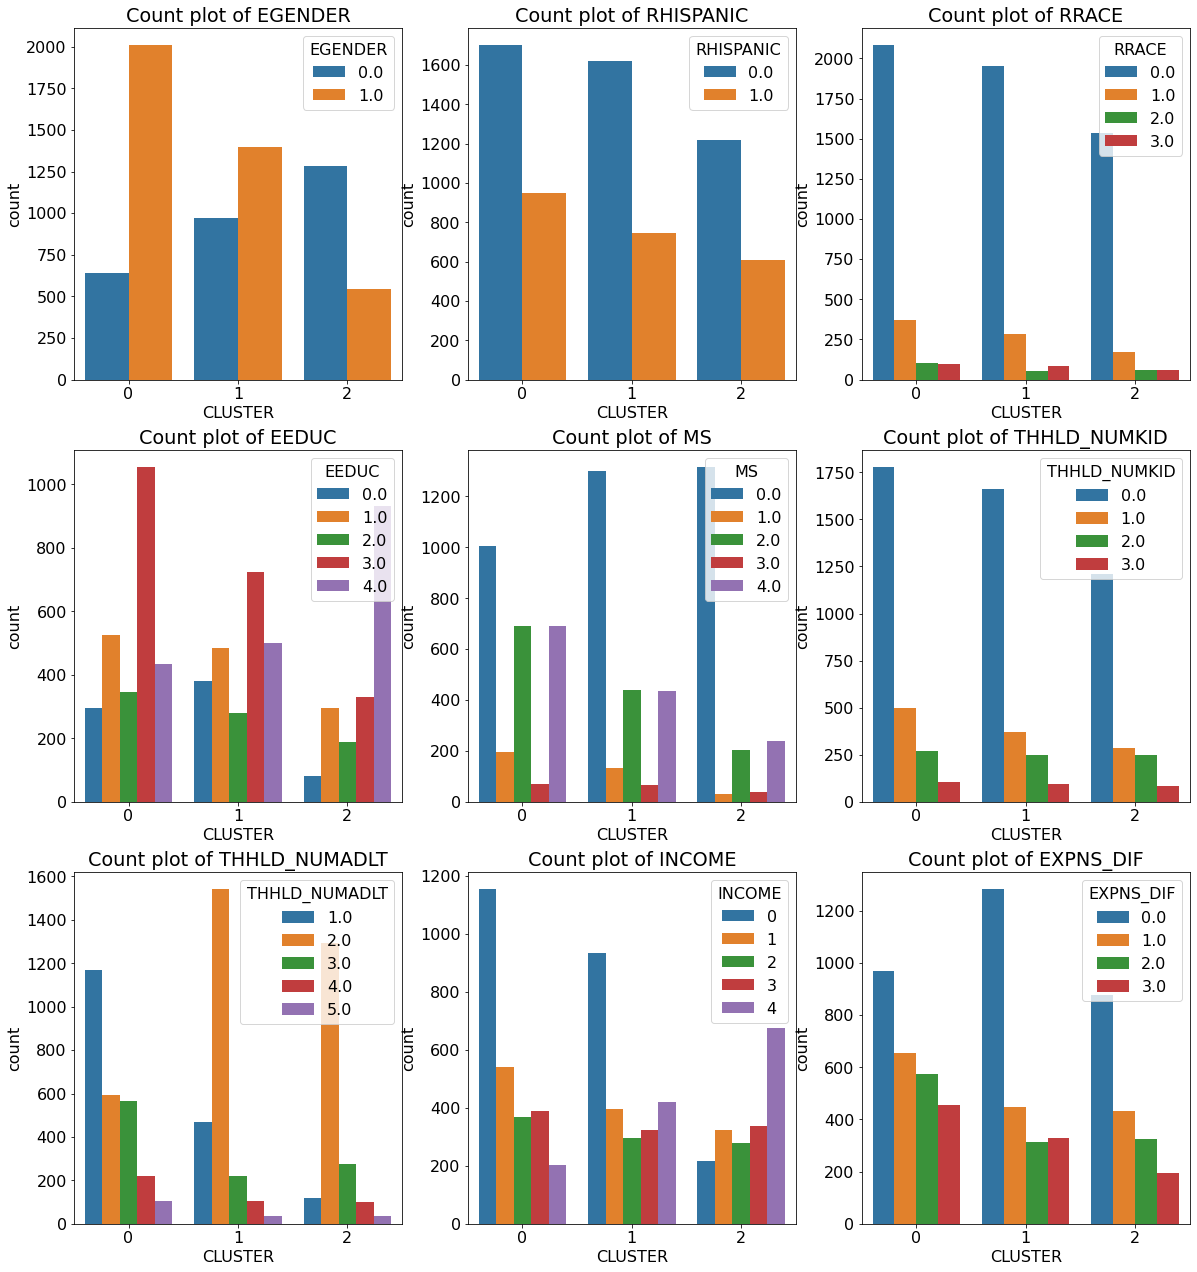

In [51]:
plt.figure(figsize=(20,22))
vars_to_look = demographics
_ = plt.rcParams.update({'font.size': 16})
for i, var in enumerate(vars_to_look):
    plt.subplot(3,3,i+1)
    if i ==10:
        plt.xticks(rotation = 90)
    sns.countplot(x='CLUSTER', hue=var, data=df_miami1)
    plt.title("Count plot of " + var)    

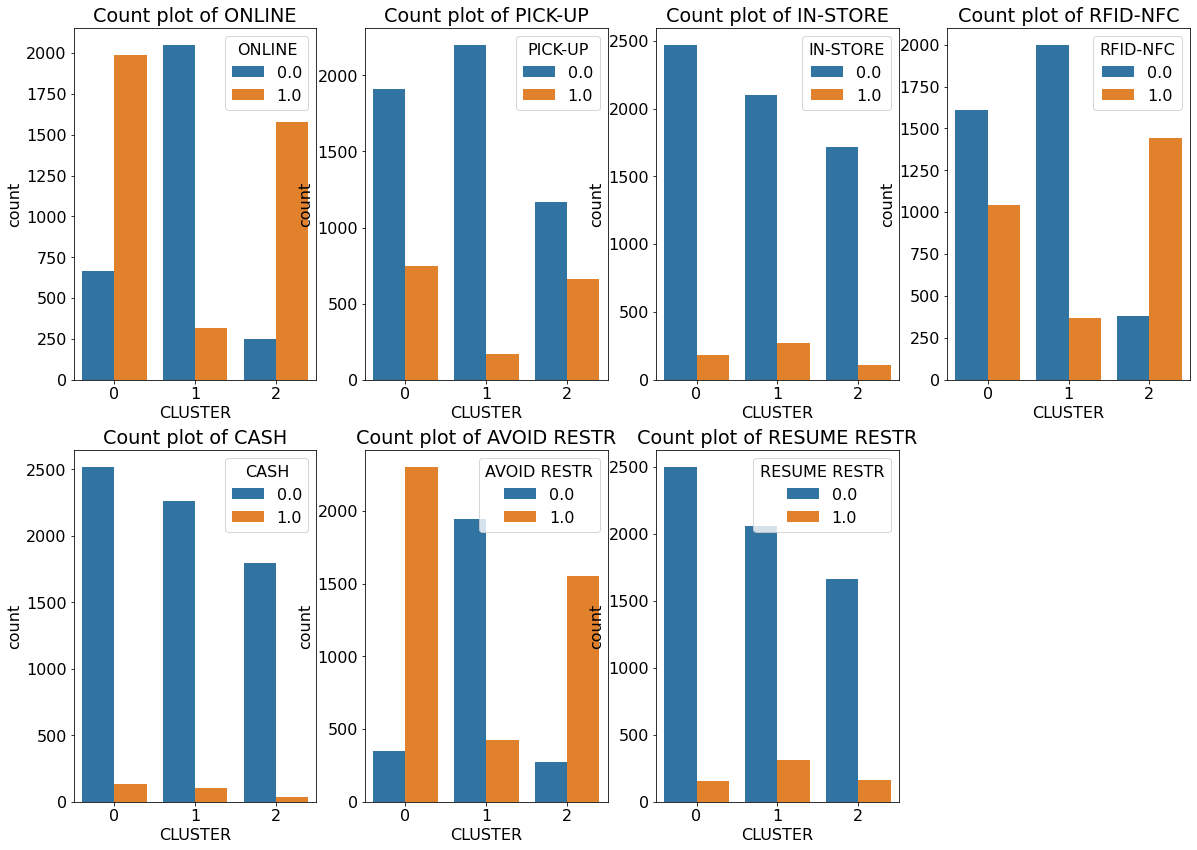

In [52]:
plt.figure(figsize=(20,22))
vars_to_look = shopping_vars
_ = plt.rcParams.update({'font.size': 16})
for i, var in enumerate(vars_to_look):
    plt.subplot(3,4,i+1)
    if i ==10:
        plt.xticks(rotation = 90)
    sns.countplot(hue=var, x='CLUSTER', data=df_miami1)
    plt.title("Count plot of " + var)    

In [53]:
def cross_tab(df, var1, var2):
    temp = df.groupby([var1, var2]).count()
    return temp/temp.groupby(level=[0]).sum()*100

In [54]:
for d in demographics:
    df = cross_tab(df_miami1, 'CLUSTER', d)
    print(df)

                 RHISPANIC      RRACE      EEDUC         MS  THHLD_NUMKID  \
CLUSTER EGENDER                                                             
0       0.0      24.189902  24.189902  24.189902  24.189902     24.189902   
        1.0      75.810098  75.810098  75.810098  75.810098     75.810098   
1       0.0      40.953184  40.953184  40.953184  40.953184     40.953184   
        1.0      59.046816  59.046816  59.046816  59.046816     59.046816   
2       0.0      70.333881  70.333881  70.333881  70.333881     70.333881   
        1.0      29.666119  29.666119  29.666119  29.666119     29.666119   

                 THHLD_NUMADLT     INCOME  EXPNS_DIF     ONLINE    PICK-UP  \
CLUSTER EGENDER                                                              
0       0.0          24.189902  24.189902  24.189902  24.189902  24.189902   
        1.0          75.810098  75.810098  75.810098  75.810098  75.810098   
1       0.0          40.953184  40.953184  40.953184  40.953184  40.953

In [55]:
for d in shopping_vars:
    df = cross_tab(df_miami1, 'CLUSTER', d)
    print(df)

                  EGENDER  RHISPANIC      RRACE      EEDUC         MS  \
CLUSTER ONLINE                                                          
0       0.0     24.981161  24.981161  24.981161  24.981161  24.981161   
        1.0     75.018839  75.018839  75.018839  75.018839  75.018839   
1       0.0     86.545761  86.545761  86.545761  86.545761  86.545761   
        1.0     13.454239  13.454239  13.454239  13.454239  13.454239   
2       0.0     13.519431  13.519431  13.519431  13.519431  13.519431   
        1.0     86.480569  86.480569  86.480569  86.480569  86.480569   

                THHLD_NUMKID  THHLD_NUMADLT     INCOME  EXPNS_DIF    PICK-UP  \
CLUSTER ONLINE                                                                 
0       0.0        24.981161      24.981161  24.981161  24.981161  24.981161   
        1.0        75.018839      75.018839  75.018839  75.018839  75.018839   
1       0.0        86.545761      86.545761  86.545761  86.545761  86.545761   
        1.0    

In [56]:
#df_miami1.to_csv('../data/processed/clustering_miami_kmodes')

In [57]:
def get_rct(var1, var2, df):
    res = pd.crosstab(df[var2], df[var1])
    output = round( res.div(res.sum(axis = 1),axis = 0)*100, 2 )
    return output

In [58]:
for col in list(x_cols.columns):
    x_cols[col] = x_cols[col].astype('category')

In [59]:
x_cols1 = x_cols[['EGENDER', 'RHISPANIC', 'RRACE', 'EEDUC', 'MS', 'THHLD_NUMKID',
       'THHLD_NUMADLT', 'INCOME', 'EXPNS_DIF', 'ONLINE', 'PICK-UP', 'IN-STORE',
       'RFID-NFC', 'CASH', 'AVOID RESTR', 'RESUME RESTR']]

In [60]:
mca = prince.MCA(n_components=2,n_iter=3,copy=True,check_input=True,engine='auto',random_state=42)
mca = mca.fit(x_cols1)

In [61]:
mca.total_inertia_

2.125

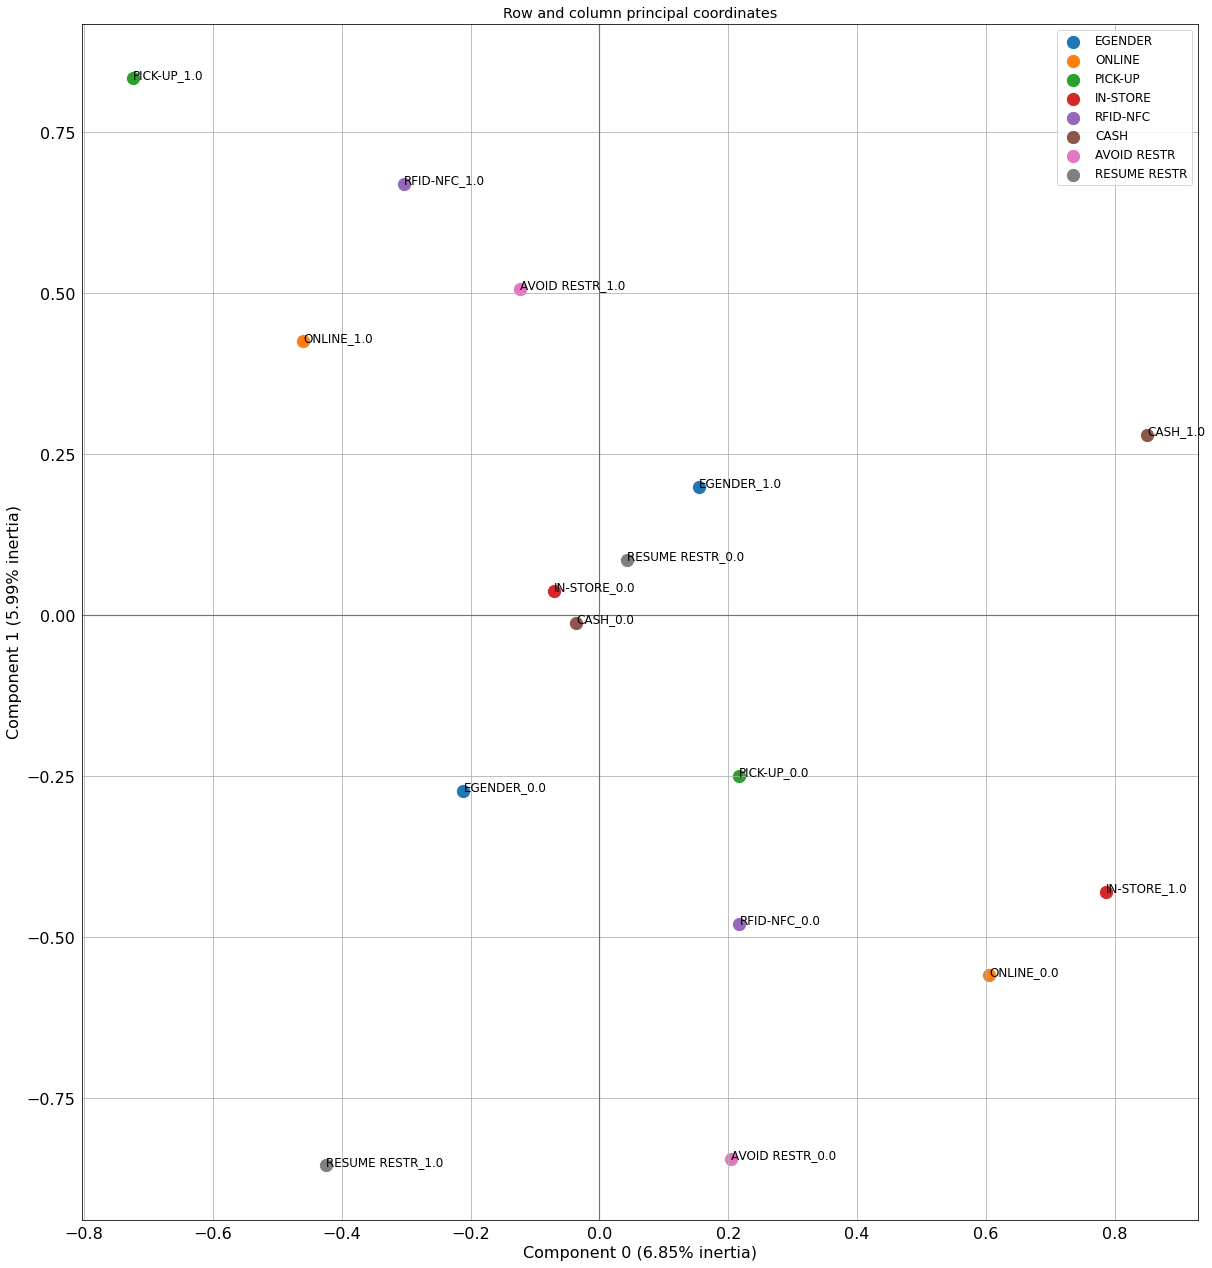

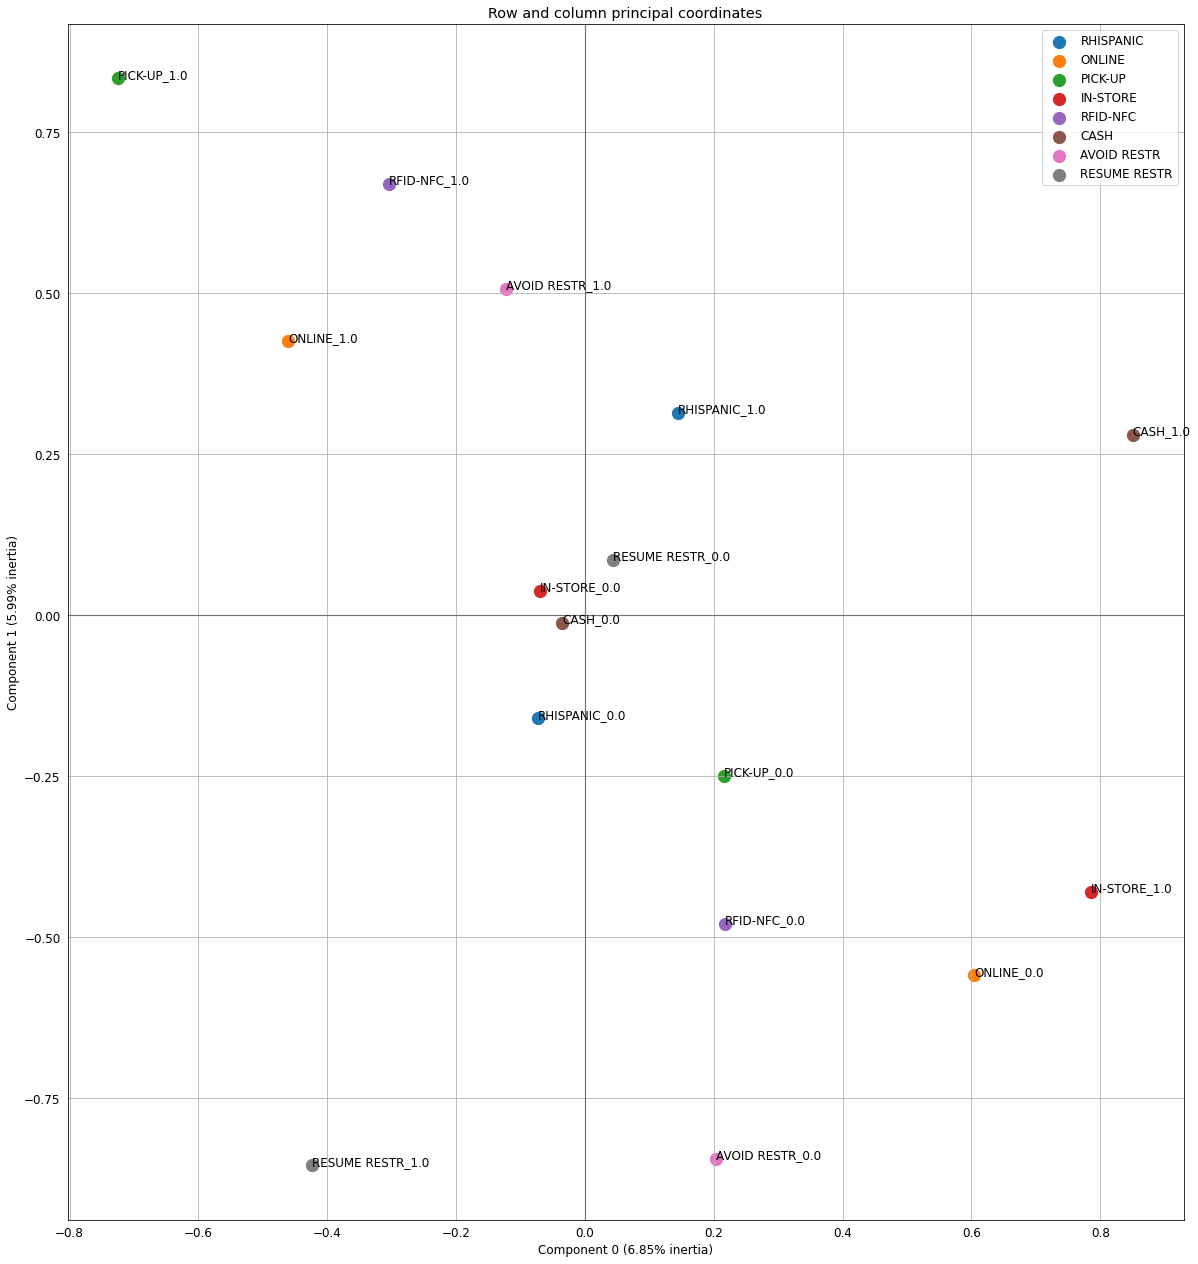

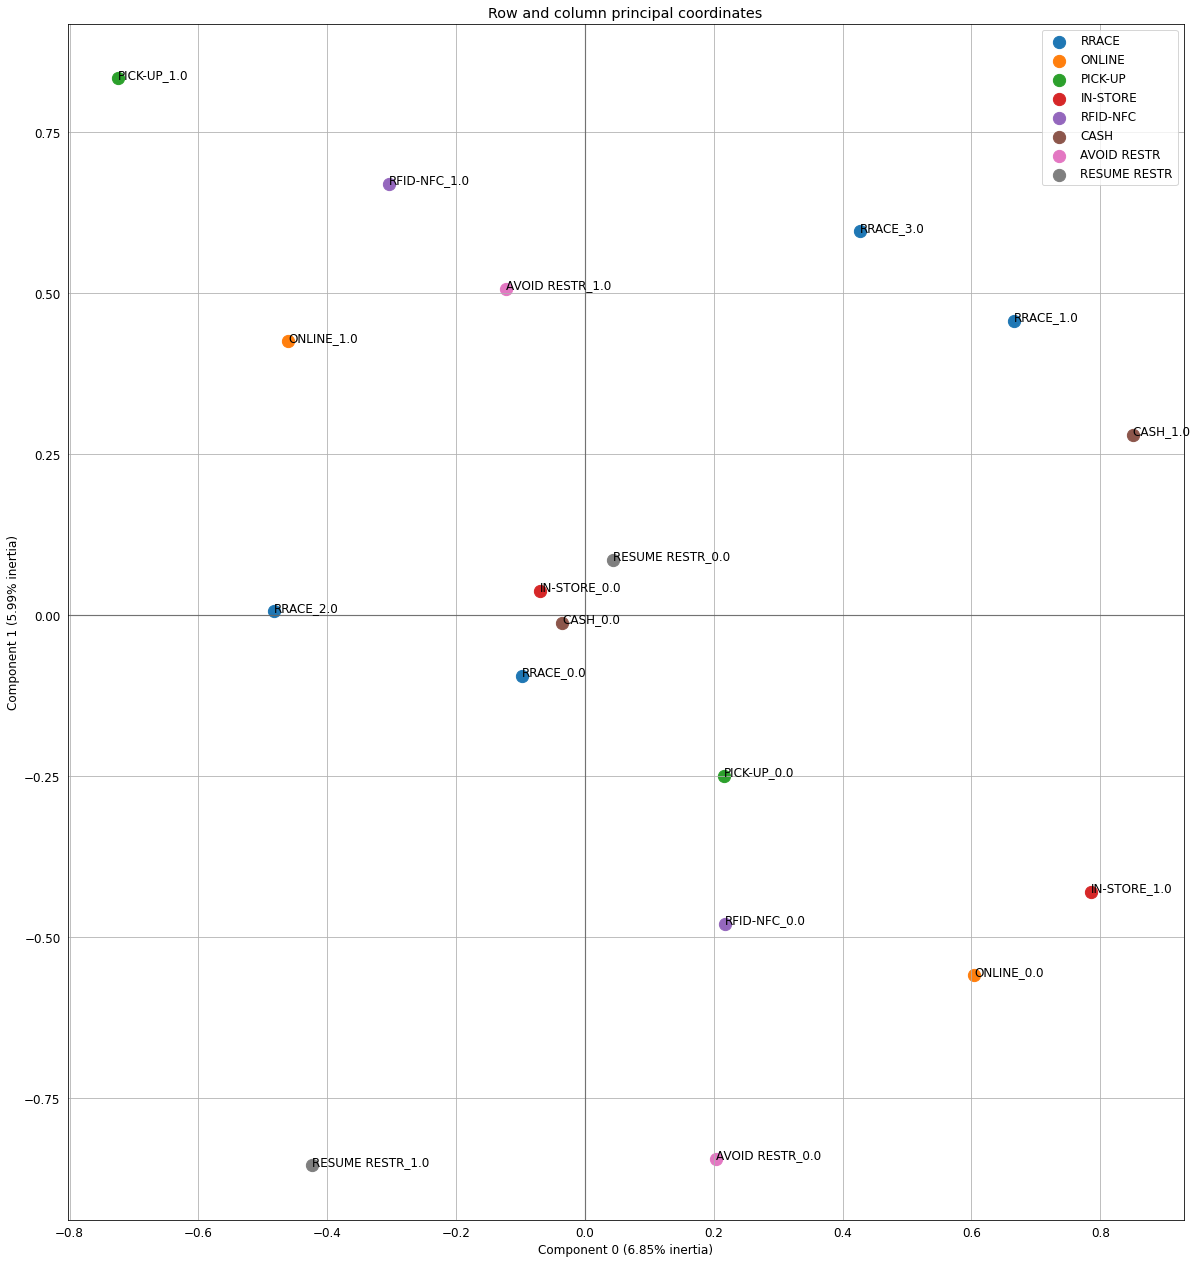

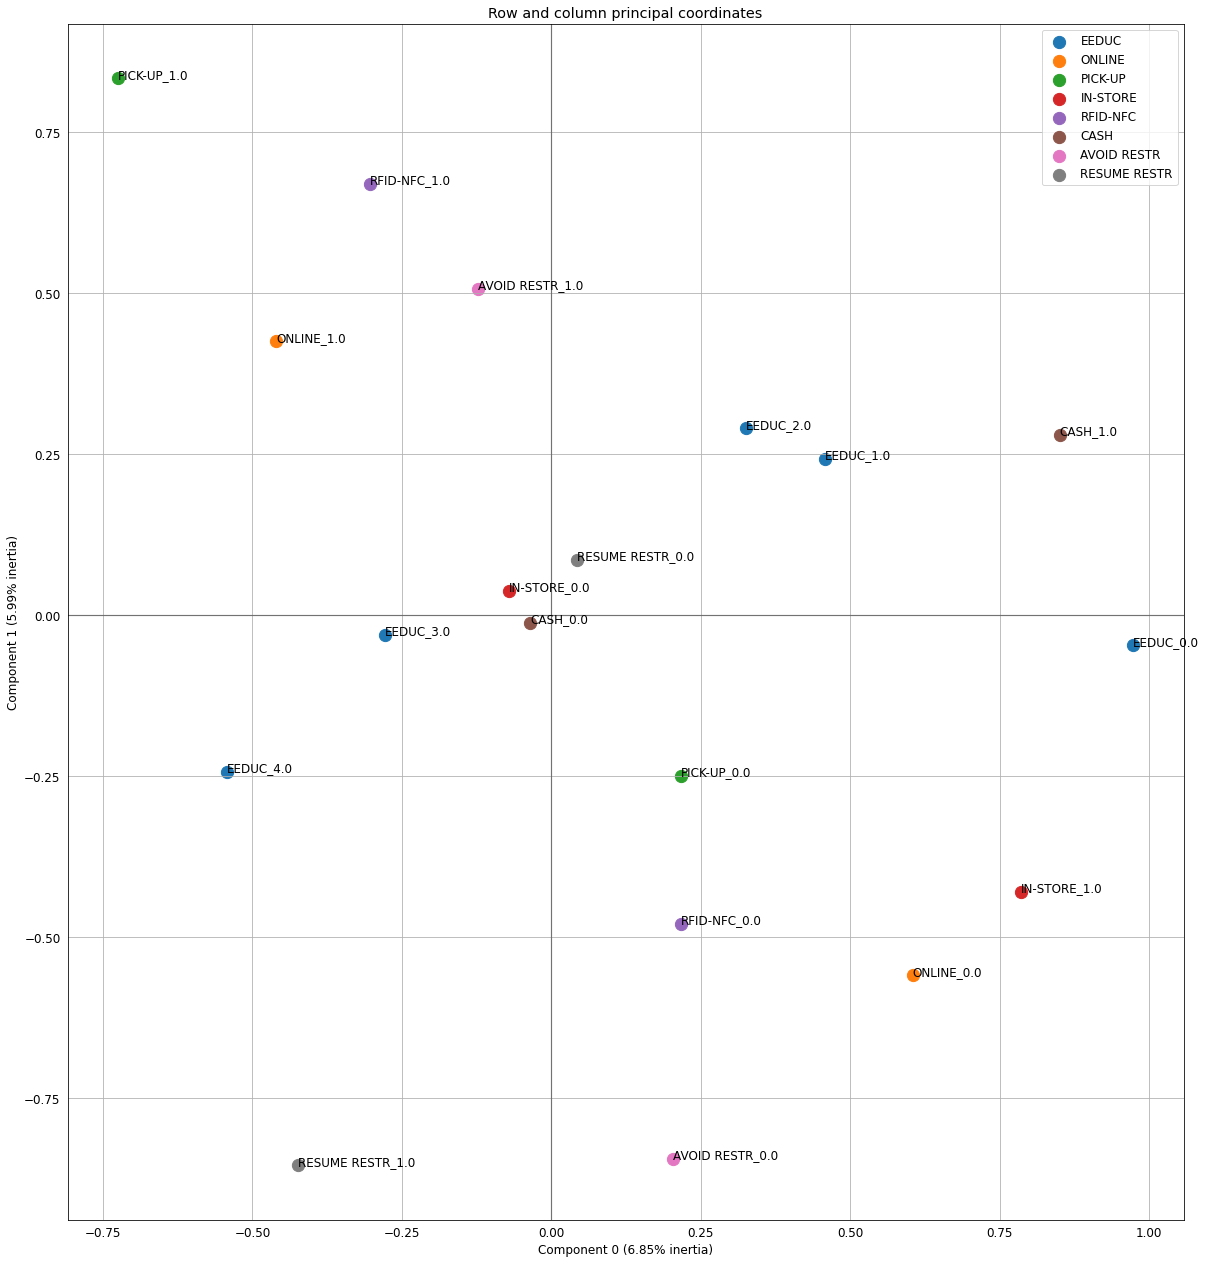

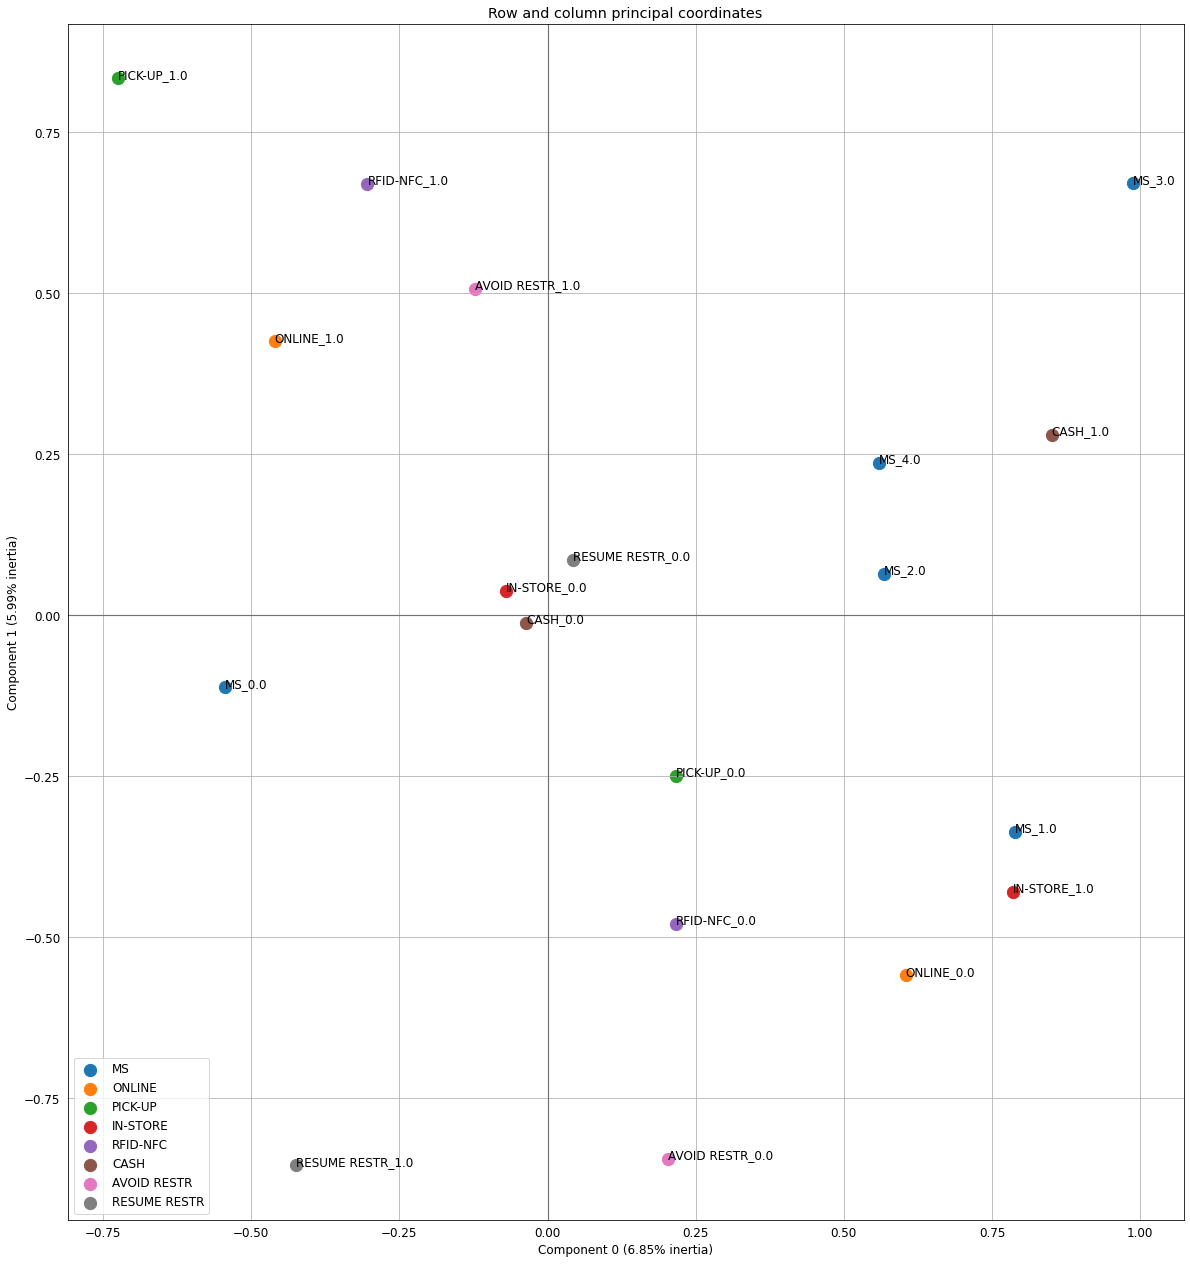

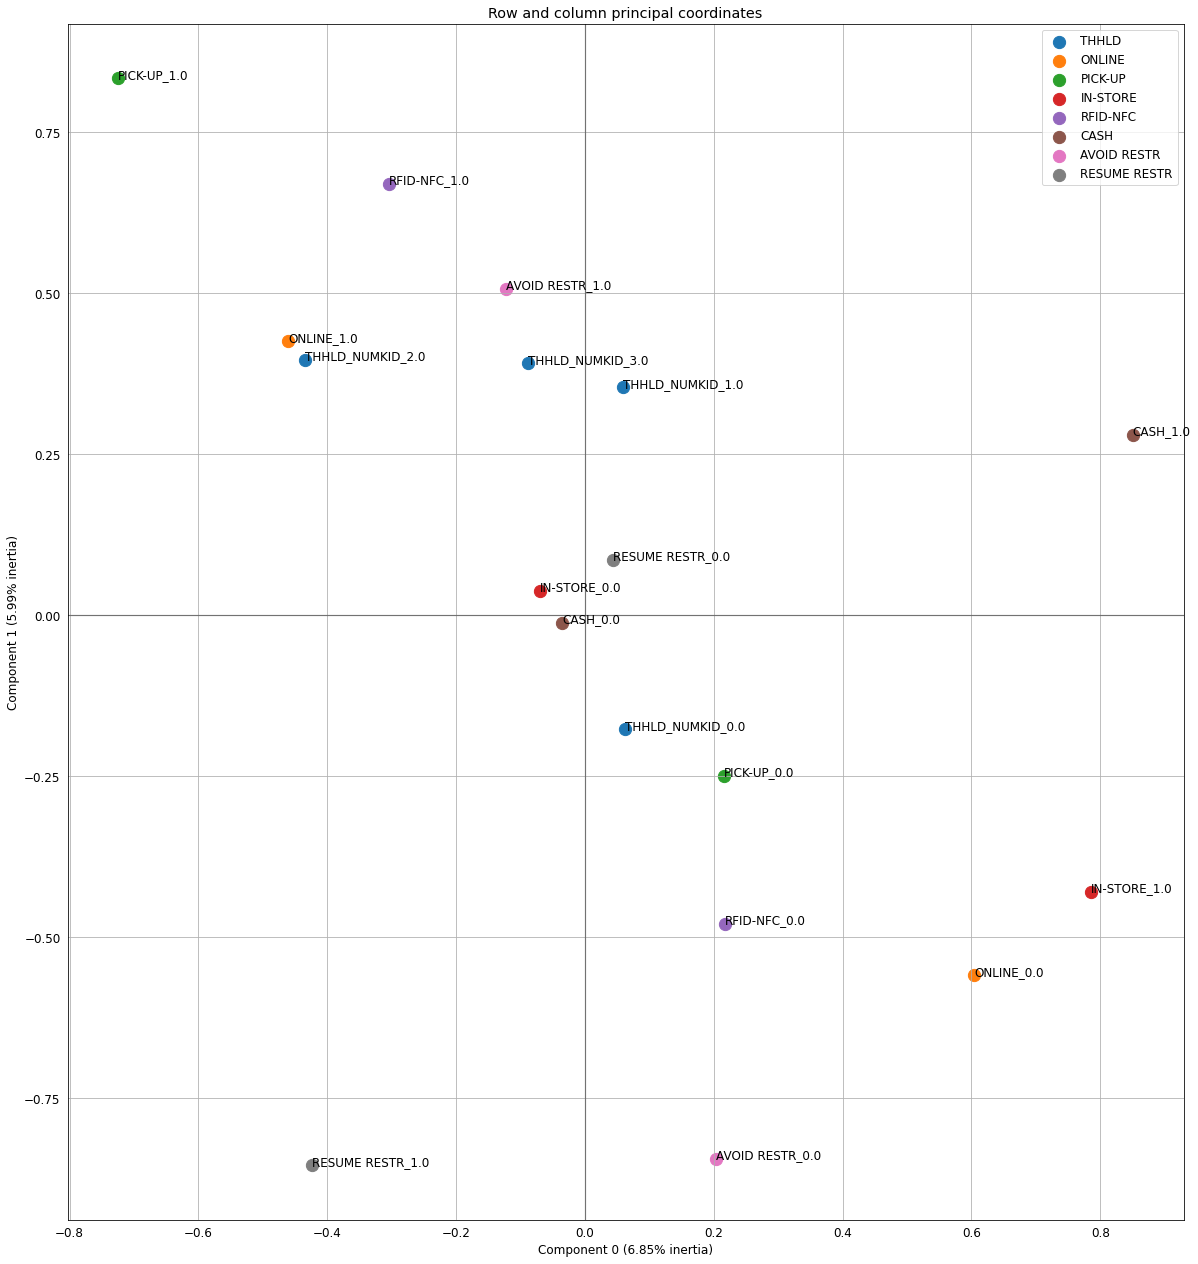

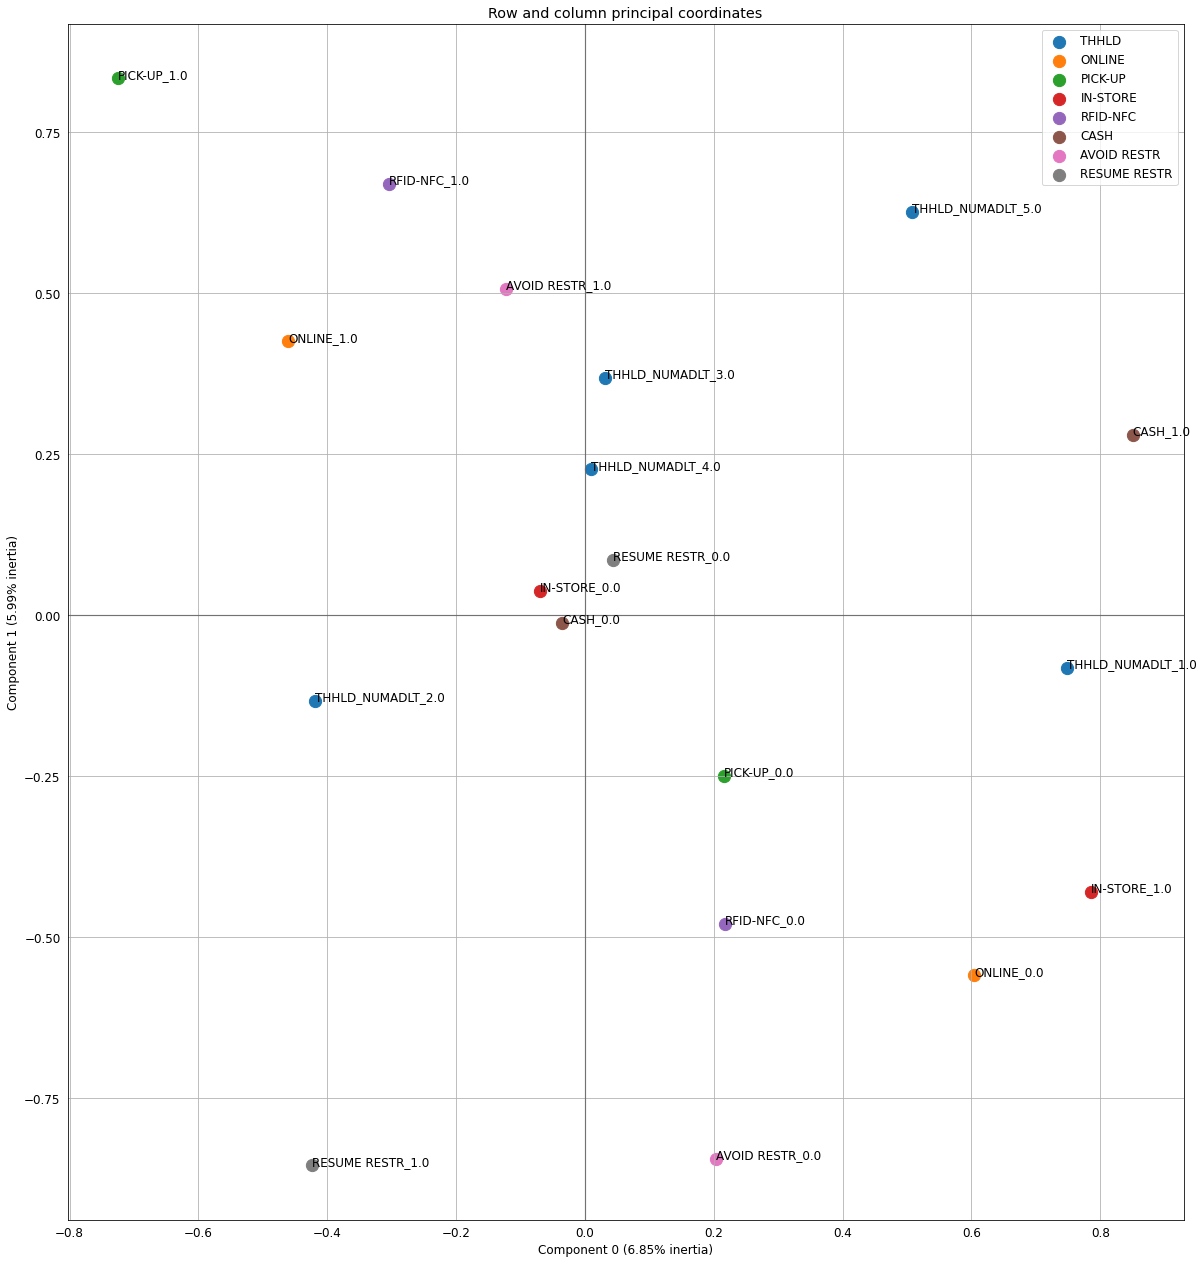

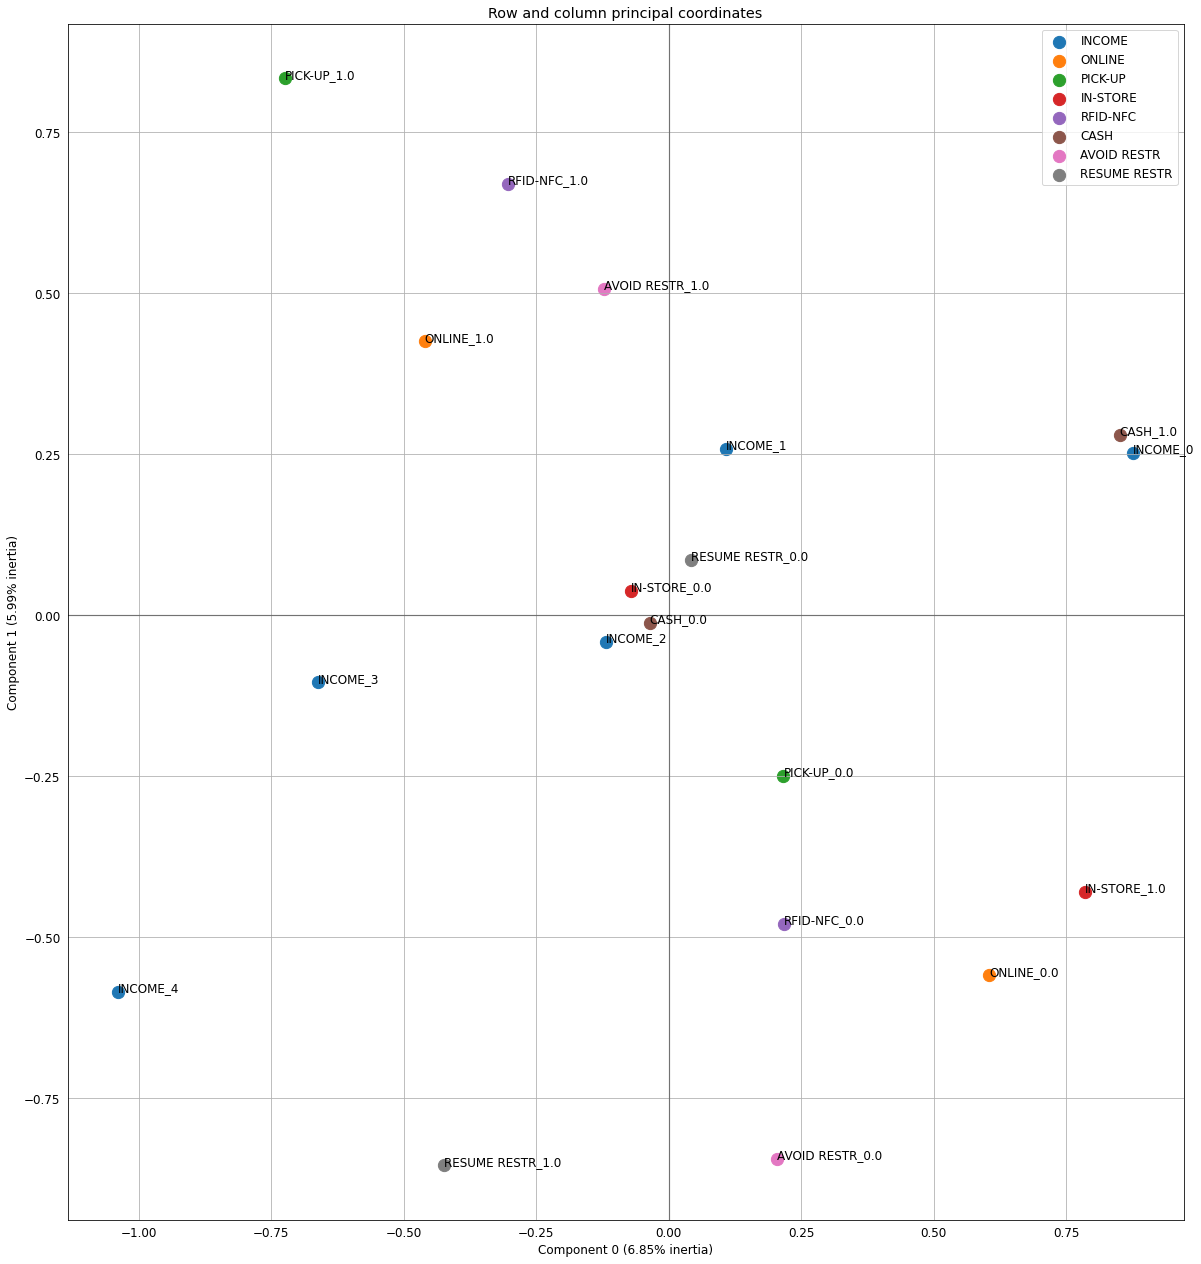

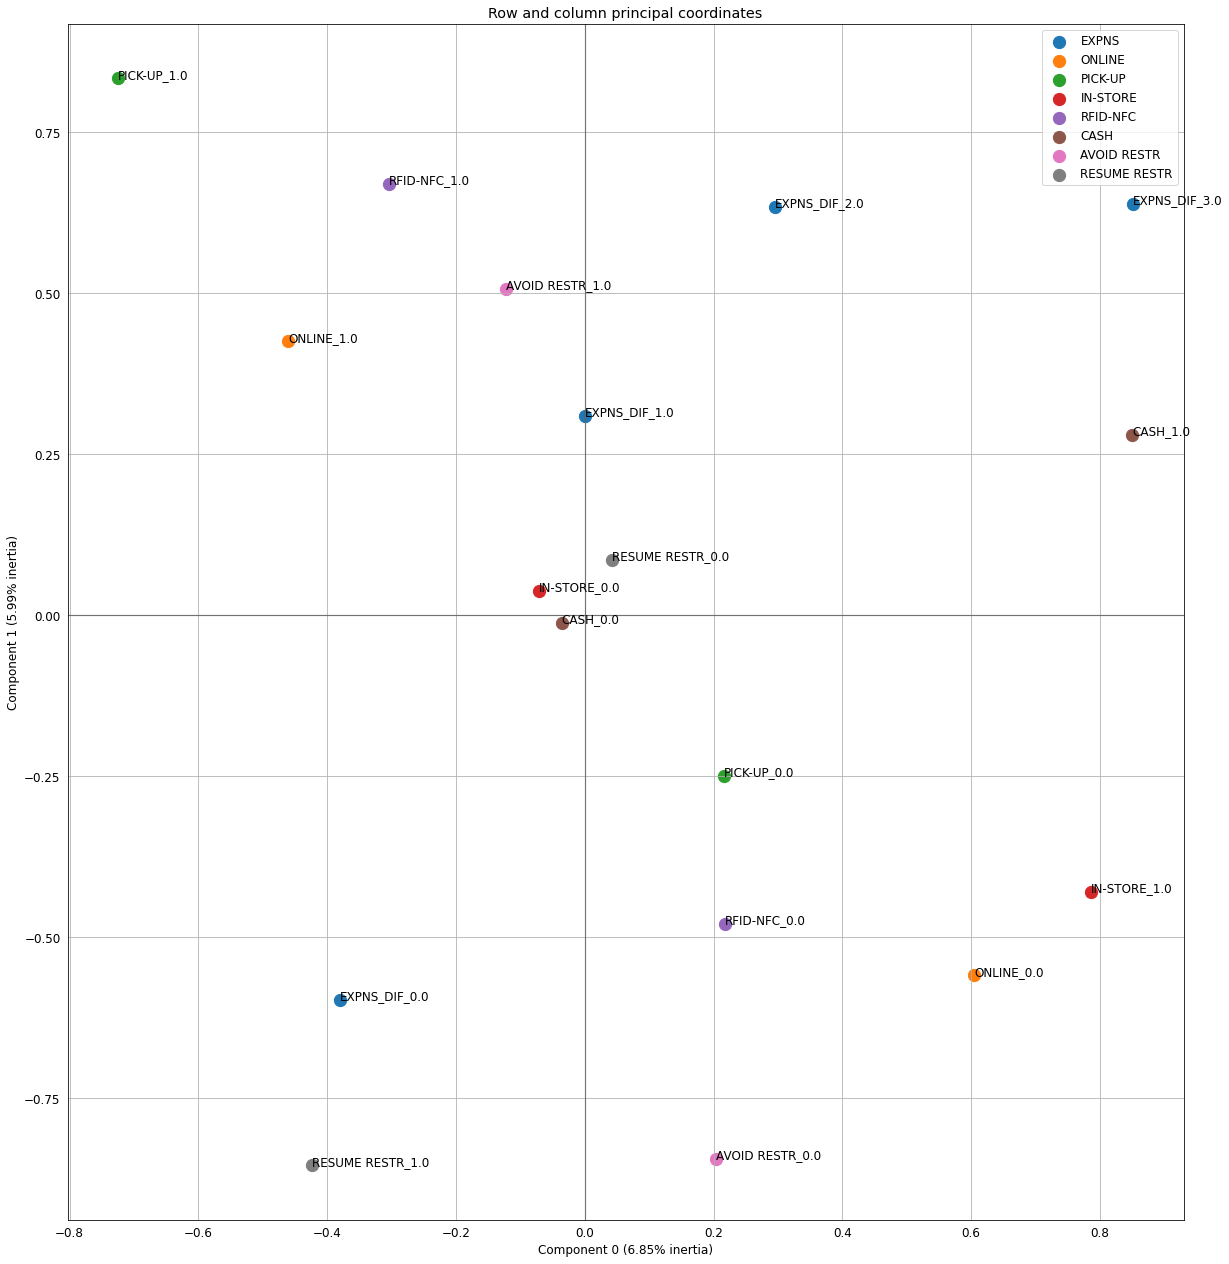

In [62]:
for d in demographics:
    fig, ax = plt.subplots(figsize=(20,22))
    _ = plt.rcParams.update({'font.size': 12})
    ax = mca.plot_coordinates(X=x_cols1[[d, 'ONLINE', 'PICK-UP', 'IN-STORE',
           'RFID-NFC', 'CASH', 'AVOID RESTR', 'RESUME RESTR']],
                              ax=ax,figsize=(6, 6), 
                              show_row_points=False,
                              row_points_size=10,
                              show_row_labels=False,
                              show_column_points=True,
                              column_points_size=150,
                              show_column_labels=True)
    _ = plt.savefig('images/mca_coordinates_'+d+'.png')
#ax.get_figure().savefig('images/mca_coordinates.svg')

In [63]:
df2 = mca.row_coordinates(x_cols1).copy()

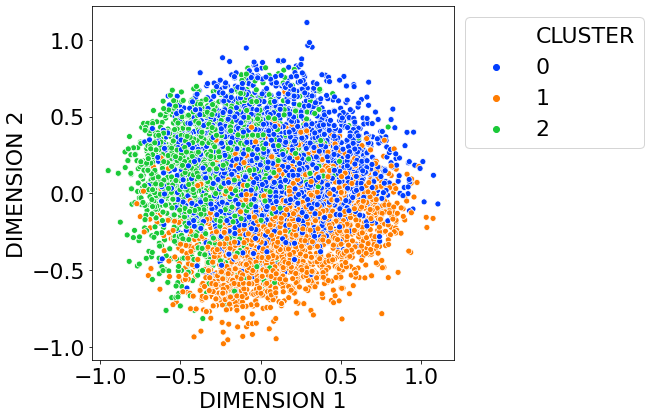

In [65]:
df_miami1['DIMENSION X'] = df2.iloc[:, 0]
df_miami1['DIMENSION Y'] = df2.iloc[:, 1]

fig, ax = plt.subplots(figsize=(6.5, 6.5))

#legend = ['GROUP A','GROUP B', 'GROUP C', 'GROUP D']
palette = sns.color_palette("bright", 3)  #Choosing color
_ = plt.rcParams.update({'font.size': 22})
_ = sns.scatterplot(x='DIMENSION X', y='DIMENSION Y', data=df_miami1, hue='CLUSTER', palette=palette)
_ = plt.xlabel('DIMENSION 1')
_ = plt.ylabel('DIMENSION 2')
_ = ax.legend(bbox_to_anchor=(1.0, 1.0))
# ax.text(-5, 2.5, 'GROUP 2')
# ax.text(3, -2.5, 'GROUP 1')
# ax.text(-4, -2.5, 'GROUP 0')
# ax.text(3, 5, 'GROUP 3')
plt.show()